# 1. Понимание бизнеса

## 1.1 Цель
Предсказать тип вин

## 1.2 Описание
The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

Attribute Information:

For more information, read [Cortez et al., 2009]. 
Input variables (based on physicochemical tests): 
1 - fixed acidity 
2 - volatile acidity 
3 - citric acid 
4 - residual sugar 
5 - chlorides 
6 - free sulfur dioxide 
7 - total sulfur dioxide 
8 - density 
9 - pH 
10 - sulphates 
11 - alcohol 
Output variable (based on sensory data): 
12 - quality (score between 0 and 10)

Acknowledgements:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy
import pandas

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib
from matplotlib import pyplot, pylab
import seaborn

# Configure visualisations
%matplotlib inline
matplotlib.style.use( 'ggplot' )
seaborn.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms(dataFrame , variables , n_rows , n_cols ):
    fig = pyplot.figure( figsize = ( 16 , 12 ) )
    for index, var_name in enumerate( variables ):
        ax = fig.add_subplot(n_rows, n_cols, index + 1)
        dataFrame[var_name].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( dataFrame[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    pyplot.show()

def show_distribution(dataFrame, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = seaborn.FacetGrid(
        dataFrame, 
        hue=target, 
        aspect=4, 
        row=row, 
        col=col)
    facet.map(seaborn.kdeplot, var, shade=True)
    facet.set(xlim=(0, dataFrame[var].max()))
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = seaborn.FacetGrid( df , row = row , col = col )
    facet.map( seaborn.barplot , cat , target )
    facet.add_legend()

def show_correlation_map(dataFrame):
    corr = dataFrame.corr()
    _ , ax = pyplot.subplots(figsize=(12, 10))
    cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
    mask = numpy.zeros_like(corr)
    mask[numpy.triu_indices_from(mask)] = True

    _ = seaborn.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 },
        mask=mask)

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pandas.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pandas.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def show_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    show_model_var_imp(tree, X, y)
    
def show_model_var_imp(model, X, y):
    imp = pandas.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [3]:
from sklearn.model_selection import train_test_split

wine_data = pandas.read_csv("winequalityN.csv")
wine_data['type'] = wine_data['type'].map({ 'white': 1, 'red': 0 })
wine_train, wine_test = train_test_split(wine_data, test_size=0.2)


print('Datasets:' , 'full:' , wine_data.shape , 'titanic:' , wine_train.shape)

Datasets: full: (6497, 13) titanic: (5197, 13)


## 2.4 Статистика и визуализации

In [4]:
wine_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5197 entries, 4717 to 74
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5197 non-null   int64  
 1   fixed acidity         5189 non-null   float64
 2   volatile acidity      5191 non-null   float64
 3   citric acid           5195 non-null   float64
 4   residual sugar        5195 non-null   float64
 5   chlorides             5195 non-null   float64
 6   free sulfur dioxide   5197 non-null   float64
 7   total sulfur dioxide  5197 non-null   float64
 8   density               5197 non-null   float64
 9   pH                    5190 non-null   float64
 10  sulphates             5193 non-null   float64
 11  alcohol               5197 non-null   float64
 12  quality               5197 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 568.4 KB


In [5]:
wine_train.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4717,1,4.8,0.225,0.38,1.2,0.074,47.0,130.0,0.99132,3.31,0.40,10.3,6
5664,0,8.8,0.590,0.18,2.9,0.089,12.0,74.0,0.99738,3.14,0.54,9.4,5
5881,0,9.1,0.500,0.30,1.9,0.065,8.0,17.0,0.99774,3.32,0.71,10.5,6
4146,1,7.1,0.130,0.29,15.5,0.064,56.0,115.5,0.99737,3.16,0.41,9.7,7
500,1,7.2,0.280,0.54,16.7,0.045,54.0,200.0,0.99900,3.08,0.49,9.5,6


**Описание переменных**

 - fixed acidity
 - volatile acidity
 - citric acid
 - residual sugar
 - chlorides
 - free sulfur dioxide
 - total sulfur dioxide
 - density
 - pH
 - sulphates
 - alcohol
 - quality


### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

In [6]:
wine_train.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5197.000000,5189.000000,5191.000000,5195.000000,5195.000000,5195.000000,5197.000000,5197.000000,5197.000000,5190.000000,5193.000000,5197.000000,5197.000000
mean,0.754474,7.221362,0.338977,0.320154,5.428046,0.056088,30.550414,115.638060,0.994693,3.217759,0.532228,10.494412,5.816625
std,0.430440,1.301451,0.163922,0.144204,4.767772,0.034473,17.873760,56.435658,0.003026,0.160001,0.150439,1.190761,0.880050
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992300,3.110000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994860,3.210000,0.510000,10.300000,6.000000
75%,1.000000,7.700000,0.400000,0.400000,8.000000,0.066000,41.000000,156.000000,0.996950,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

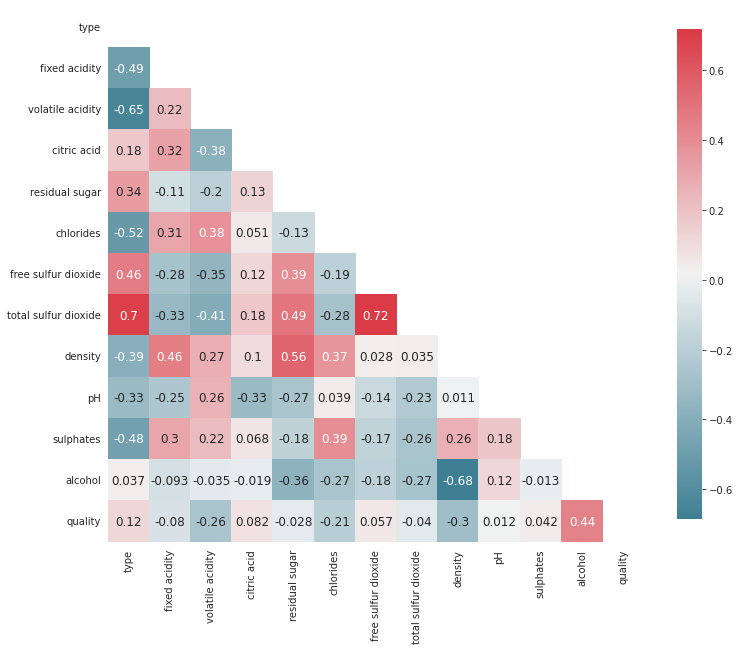

In [7]:
show_correlation_map(wine_train)

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками
Начнем с рассмотрения взаимосвязи между total sulfur dioxide и type.

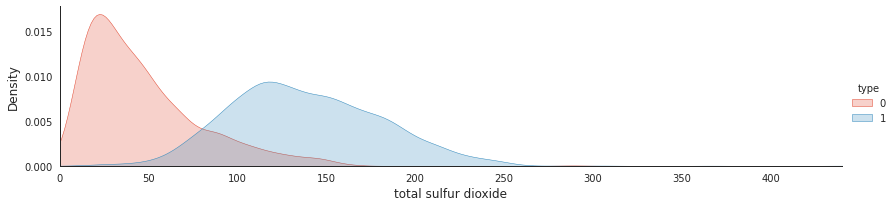

In [8]:
show_distribution(wine_train, var='total sulfur dioxide', target='type')

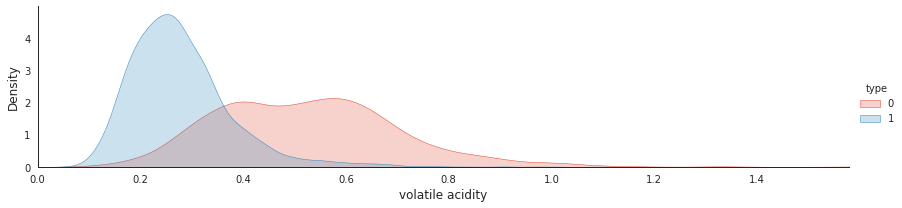

In [9]:
show_distribution(wine_train, var='volatile acidity', target='type')

Рассмотрим графики выше. Различия между выживаемостью для разных значений - это то, что будет использоваться для разделения целевой переменной (в данном случае - выживаемости) в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для нашей прогностической модели.

# 3. Data Preparation

## 3.1 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [10]:
for column in ['volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
  wine_train[column] = wine_train[column].fillna(wine_train[column].mean())

wine_train = wine_train.dropna()
wine_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5189 entries, 4717 to 74
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5189 non-null   int64  
 1   fixed acidity         5189 non-null   float64
 2   volatile acidity      5189 non-null   float64
 3   citric acid           5189 non-null   float64
 4   residual sugar        5189 non-null   float64
 5   chlorides             5189 non-null   float64
 6   free sulfur dioxide   5189 non-null   float64
 7   total sulfur dioxide  5189 non-null   float64
 8   density               5189 non-null   float64
 9   pH                    5189 non-null   float64
 10  sulphates             5189 non-null   float64
 11  alcohol               5189 non-null   float64
 12  quality               5189 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 567.5 KB


## 3.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [11]:
train_X = wine_train.drop(['type'], axis=1).dropna()
train_y = wine_train['type']

wine_test = wine_test.dropna()
test_X = wine_test.drop(['type'], axis=1)
test_y = wine_test['type']

## 3.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

0.9998072846405859


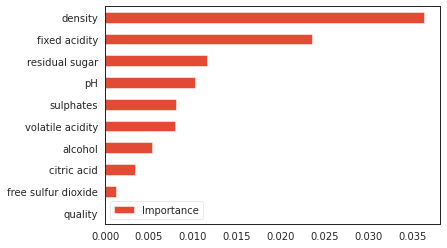

In [12]:
show_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [13]:
model = LogisticRegression()

## 4.2 Обучение модели

In [14]:
model.fit(train_X , train_y)

LogisticRegression()

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [15]:
# Score the model
print(model.score(train_X, train_y), model.score(test_X, test_y))

0.9799576026209289 0.9760432766615147


# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.